In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time
from torch.utils.data import random_split


import matplotlib.pyplot as plt
from IPython.display import clear_output

## Load data

In [2]:
data_path = '/dtu/datasets1/02516/PH2_Dataset_images'

class PhC(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path):
        'Initialization'
        self.transform = transform

        # Assuming folder structure: /dtu/datasets1/02516/CMP_facade_DB_base/IMDXXX/IMDXXX_Dermoscopic_Image/IMDXXX.bmp
        self.image_paths = sorted(glob.glob(os.path.join(data_path, 'IMD*/IMD*_Dermoscopic_Image/*.bmp')))
        
        # Assuming folder structure: /dtu/datasets1/02516/CMP_facade_DB_base/IMDXXX/IMDXXX_lesion/IMDXXX_lesion.bmp
        self.label_paths = sorted(glob.glob(os.path.join(data_path, 'IMD*/IMD*_lesion/*.bmp')))

        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        
        image = Image.open(image_path)
        label = Image.open(label_path)

        image_size = image.size

        Y = self.transform(label)
        X = self.transform(image)
        return X, Y

In [3]:
size = 128
batch_size = 6

train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

data = PhC(train=True, transform=train_transform, data_path=data_path)

# train validation and test set sizes
dataset_size = len(data)
train_size = int(0.8 * dataset_size)  # 80% for training
val_test_size = dataset_size - train_size
val_size = val_test_size // 2  # 10% for validation
test_size = val_test_size - val_size  # 10% for testing

# Use random_split to split the dataset
train_set, val_set, test_set = random_split(data, [train_size, val_size, test_size])

# Create DataLoader 
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=3)
validation_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=3)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=3)

In [4]:
# Print the sizes of the sets
print('Loaded %d images' % len(data))
print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Loaded 200 images
Training set size: 160
Validation set size: 20
Test set size: 20


## Show data

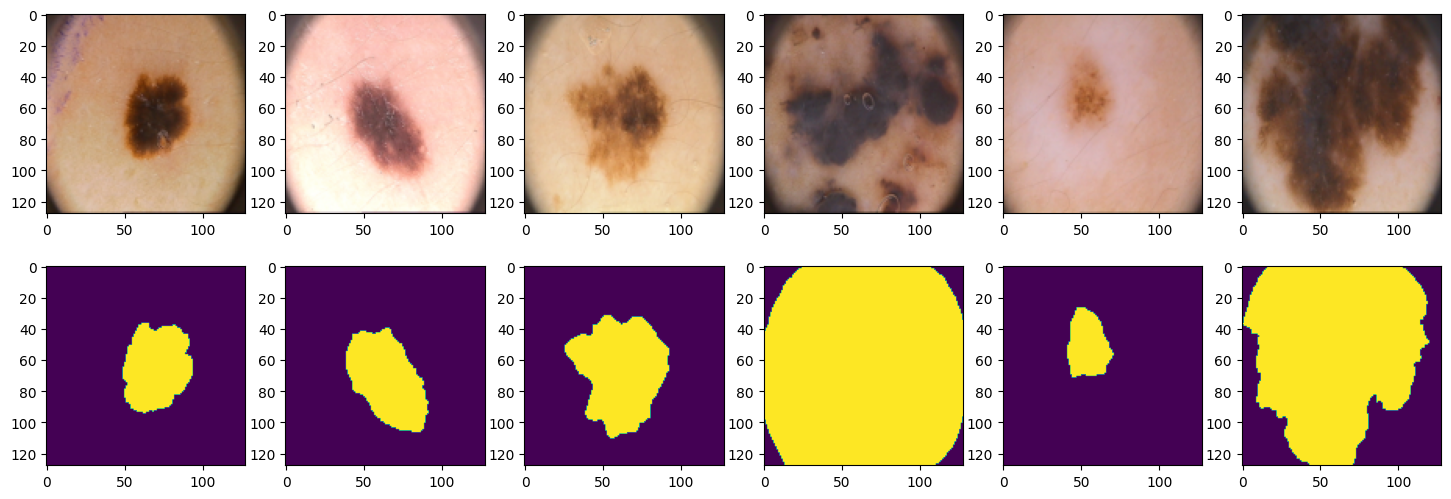

In [5]:
plt.rcParams['figure.figsize'] = [18, 6]

images, labels= next(iter(train_loader))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))

    plt.subplot(2, 6, i+7)
    plt.imshow(labels[i].squeeze())
plt.show()

In [6]:
sizes

[tensor([767, 767, 767, 768, 767, 765]),
 tensor([576, 576, 576, 576, 576, 575])]

## Device

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Simple encoder-decoder segmentation CNN

In [7]:
class EncDec(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(16)  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

## Loss

In [8]:
def bce_loss(y_real, y_pred):
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

## Metrics

In [9]:
def dice_coefficient(predicted, target):
    intersection = torch.sum(predicted * target) * 2.0
    union = torch.sum(predicted) + torch.sum(target) + 1e-7  # Adding a small epsilon to avoid division by zero
    return intersection / union

def intersection_over_union(predicted, target):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target) - intersection + 1e-7
    return intersection / union

def accuracy(predicted, target):
    correct_pixels = torch.sum(predicted == target).item()
    total_pixels = target.numel()
    return correct_pixels / total_pixels

def sensitivity(predicted, target):
    true_positive = torch.sum((predicted == 1) & (target == 1)).item()
    actual_positive = torch.sum(target == 1).item()
    return true_positive / (actual_positive + 1e-7)

def specificity(predicted, target):
    true_negative = torch.sum((predicted == 0) & (target == 0)).item()
    actual_negative = torch.sum(target == 0).item()
    return true_negative / (actual_negative + 1e-7)

def compute_metrics(predicted, target):
    predicted_binary = (predicted > 0.5).float()
    
    dice = dice_coefficient(predicted_binary, target)
    iou = intersection_over_union(predicted_binary, target)
    acc = accuracy(predicted_binary, target)
    sens = sensitivity(predicted_binary, target)
    spec = specificity(predicted_binary, target)

    return dice.item(), iou.item(), acc, sens, spec

def evaluate(model, loader, loss_fn):
    model.eval()
    avg_loss = 0
    all_metrics = {'dice': 0, 'iou': 0, 'accuracy': 0, 'sensitivity': 0, 'specificity': 0}

    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            avg_loss += loss.item() / len(loader)

            metrics = compute_metrics(Y_pred, Y_batch)
            for metric_name, metric_value in zip(all_metrics.keys(), metrics):
                all_metrics[metric_name] += metric_value / len(loader)

    return avg_loss, all_metrics


## Training

In [10]:
def train(model, opt, loss_fn, epochs, train_loader, val_loader, test_loader):
    X_test, Y_test = next(iter(test_loader))
    train_losses = []
    val_losses = []
    test_losses = []

    val_metrics = {'dice': [], 'iou': [], 'accuracy': [], 'sensitivity': [], 'specificity': []}
    test_metrics = {'dice': [], 'iou': [], 'accuracy': [], 'sensitivity': [], 'specificity': []}

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        # Training phase
        avg_train_loss = 0
        model.train()
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()

            avg_train_loss += loss.item() / len(train_loader)

        train_losses.append(avg_train_loss)
        
        # Validation phase
        val_loss, val_metrics_epoch = evaluate(model, val_loader, loss_fn)
        val_losses.append(val_loss)
        for metric_name in val_metrics_epoch.keys():
            val_metrics[metric_name].append(val_metrics_epoch[metric_name])

        # Testing phase
        test_loss, test_metrics_epoch = evaluate(model, test_loader, loss_fn)
        test_losses.append(test_loss)
        for metric_name in test_metrics_epoch.keys():
            test_metrics[metric_name].append(test_metrics_epoch[metric_name])

        toc = time()


        # Show intermediate results
        clear_output(wait=True)
        Y_hat = F.sigmoid(model(X_test.to(device))).detach().cpu()
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - Training Loss: %f, Validation Loss: %f, Test Loss: %f' % (epoch+1, epochs, avg_train_loss, val_loss, test_loss))
        plt.show()

    # Store metrics for plotting
    return train_losses, val_losses, test_losses, val_metrics, test_metrics



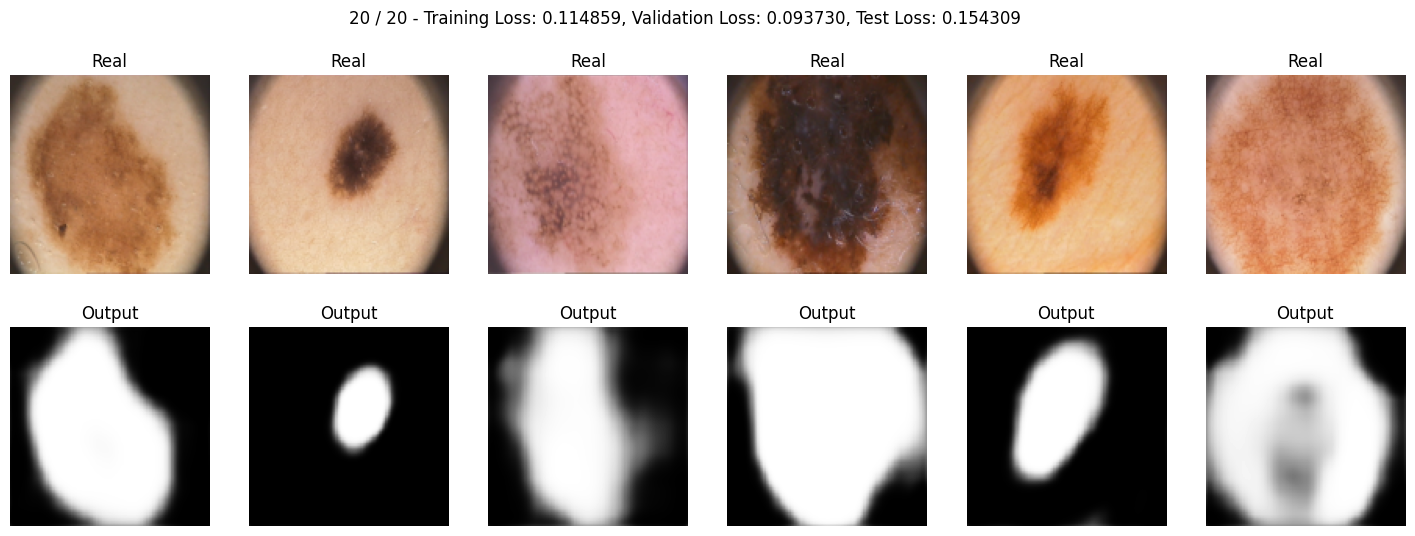

In [11]:
model = EncDec().to(device)
epochs = 20
train_losses, val_losses, test_losses, val_metrics, test_metrics = train(model, optim.Adam(model.parameters()), bce_loss, epochs, train_loader, validation_loader, test_loader) 

## Results

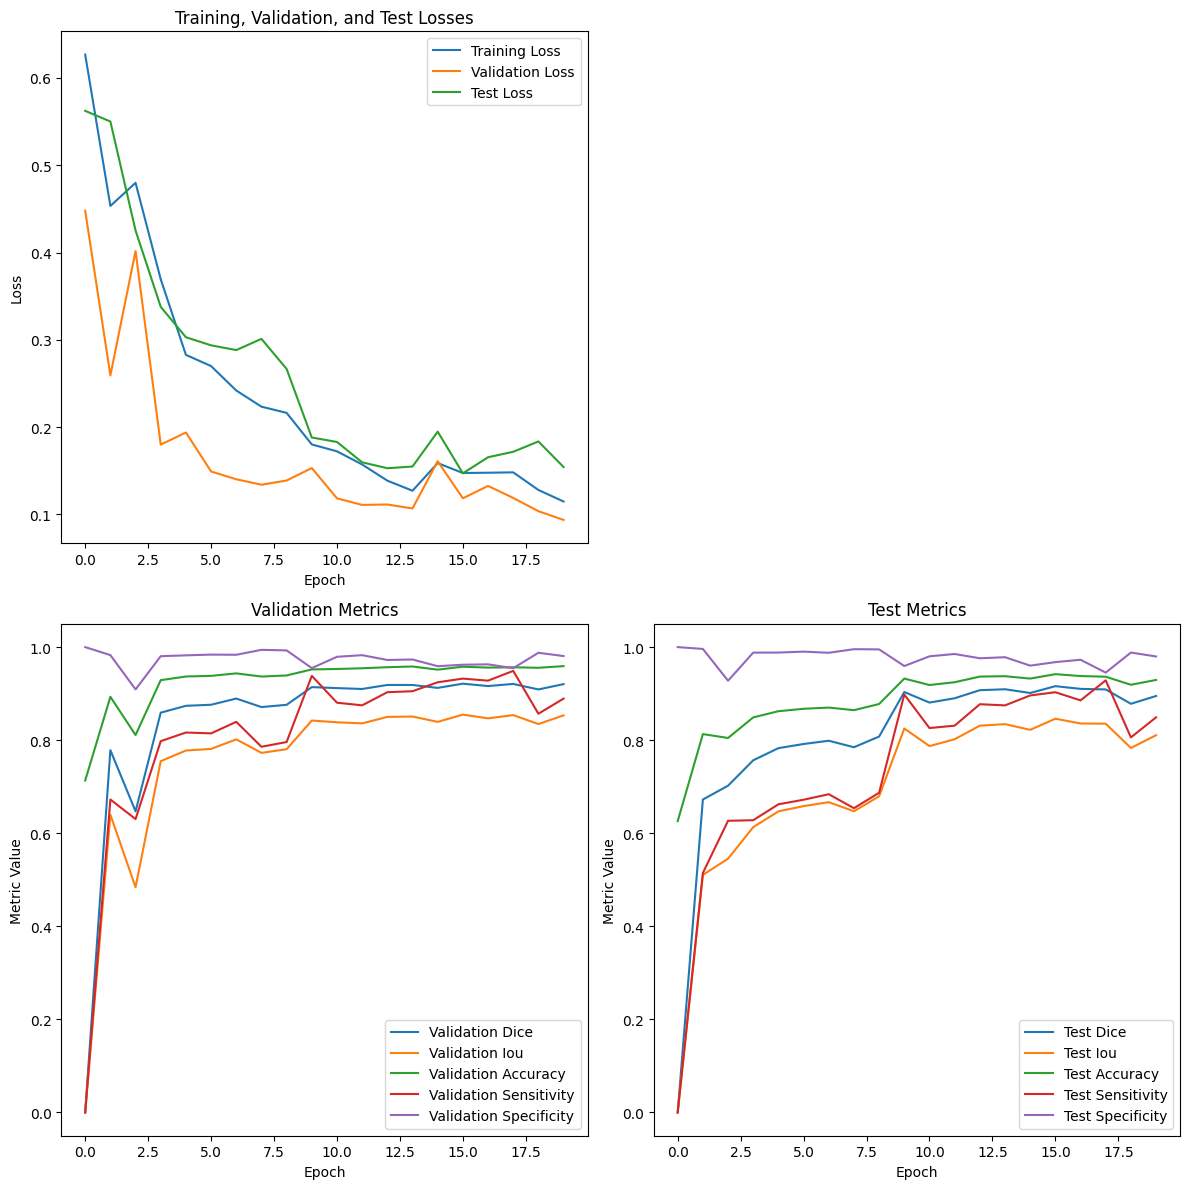

In [13]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, test_losses, val_metrics, test_metrics):
    # Plot losses
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training, Validation, and Test Losses')
    plt.legend()

    # Plot metrics

    plt.subplot(2, 2, 3)
    for metric_name in val_metrics.keys():
        plt.plot(val_metrics[metric_name], label=f'Validation {metric_name.capitalize()}')

    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title('Validation Metrics')
    plt.legend()

    plt.subplot(2, 2, 4)
    for metric_name in val_metrics.keys():
        plt.plot(test_metrics[metric_name], label=f'Test {metric_name.capitalize()}')

    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title('Test Metrics')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Plot the metrics
plot_metrics(train_losses, val_losses, test_losses, val_metrics, test_metrics)


In [14]:
# Print the last epoch's losses and metrics
last_epoch = epochs - 1
print(f"Last Epoch ({last_epoch + 1}/{epochs}):")
print(f"Training Loss: {train_losses[last_epoch]}")
print(f"Validation Loss: {val_losses[last_epoch]}")
for metric_name in val_metrics.keys():
    print(f"Validation {metric_name.capitalize()}: {val_metrics[metric_name][last_epoch]}")
print(f"Test Loss: {test_losses[last_epoch]}")
for metric_name in test_metrics.keys():
    print(f"Test {metric_name.capitalize()}: {test_metrics[metric_name][last_epoch]}")


Last Epoch (20/20):
Training Loss: 0.11485880282190111
Validation Loss: 0.09372979961335659
Validation Dice: 0.9204345792531967
Validation Iou: 0.8532631695270538
Validation Accuracy: 0.9590886433919271
Validation Sensitivity: 0.889336284338286
Validation Specificity: 0.9807202241838795
Test Loss: 0.15430865064263344
Test Dice: 0.8949176073074341
Test Iou: 0.8107084929943085
Test Accuracy: 0.929425557454427
Test Sensitivity: 0.8491150165894696
Test Specificity: 0.9799099124954608
